In [1]:
import numpy as np
import pandas as pd
import spacy
import nltk
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


c:\Users\jkim2\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**References**

https://medium.com/@piocalderon/vader-sentiment-analysis-explained-f1c4f9101cd9

# **Read Dataset**

In [2]:
tweets = pd.read_csv("./fifa_world_cup_2022_tweets.csv", encoding='utf-8')
tweets

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe \n@MadB...,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright\n\nhttps://t.co/...,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative
...,...,...,...,...,...
22519,2022-11-20 00:00:21+00:00,1,Twitter Web App,Here We go World cup 2022 #WorldCup2022,positive
22520,2022-11-20 00:00:03+00:00,0,DenetPro,Anderlecht confirms former Viborg FF's Jesper ...,neutral
22521,2022-11-20 00:00:01+00:00,2,Twitter for iPhone,Great thread to read before the start of #Worl...,positive
22522,2022-11-20 00:00:00+00:00,11,Twitter Web App,Raphinha wants Brazil to be united at the #Wor...,positive


In [3]:
#Check number columns and their name
tweets.columns

Index(['Date Created', 'Number of Likes', 'Source of Tweet', 'Tweet',
       'Sentiment'],
      dtype='object')

## **1. Visualization of the Dataset**

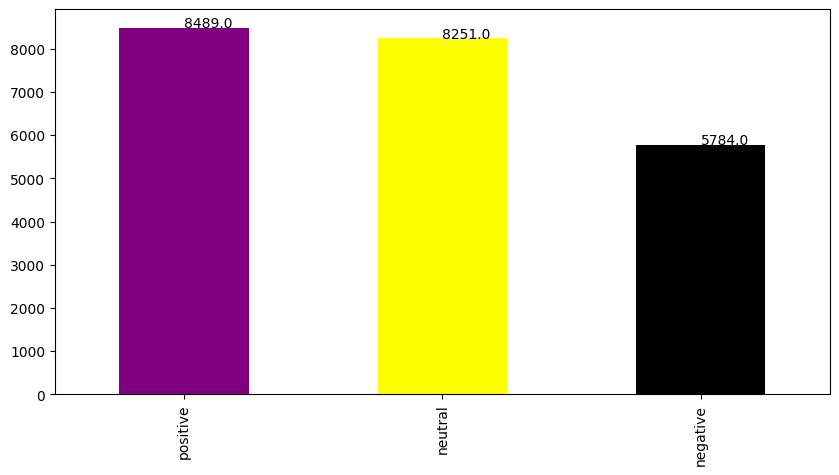

In [4]:
# Breakdown of tweets' sentiments

# setting figure size
plt.figure(figsize=(10, 5))

#make the bar chart
ax = pd.value_counts(tweets['Sentiment']).plot.bar(
    color=['purple', 'yellow', 'black'])

#call function to add value labels
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()),
               (p.get_x()+0.25, p.get_height()+0.01))
plt.show()


It looks like most of the tweets in the FIFA world cup is deemed positive. However, the predetermined sentiment tag does not seem to do well in deciding the tweets' sentiments if the emotions are not at extreme ends, resulting in a lot of neutral sentiment tags as well

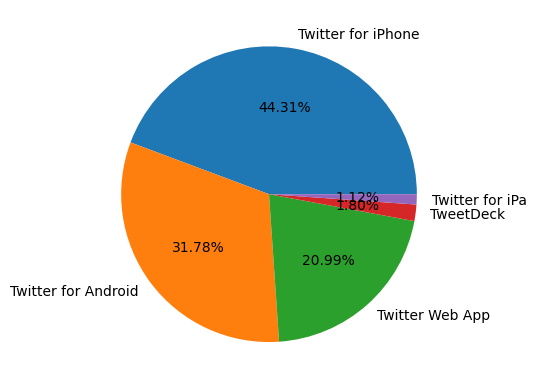

In [5]:
# plot for sources of the tweets
sources = tweets['Source of Tweet'].value_counts()[:5]
labels = ['Twitter for iPhone', 'Twitter for Android',
          'Twitter Web App', 'TweetDeck', 'Twitter for iPa']
plt.pie(sources, labels=labels, autopct='%1.2f%%')
plt.show()


Most of the tweets seem to come from mobile platform, which makes sense, because Twitter is mobile-oriented social media platform

## **2. Data Preprocessing**

### 2.1 Extract urls, hashtags, usernames and remove them from original text

In [6]:
#extract all the urls in the tweets into an object
url = tweets.Tweet.str.extract(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})').head()
url

,0
0,https://t.co/Oga3TzvG5h
1,https://t.co/7g73vvwtg8
2,https://t.co/1SQrNa2dYU
3,https://t.co/4AyZbzGTX4
4,https://t.co/f72P03ZN2k


In [7]:
# function to print all the hashtags in a text
def extract_hashtags(text):
    # splitting the text into words
    hashtags = object()
    for word in text.split():
        if word[0] == "#":
            hashtags = word[1:]
    return(hashtags)


#create an object to store all the hashtags in tweets
tweets['hashtags'] = tweets['Tweet'].apply(lambda x: extract_hashtags(x))


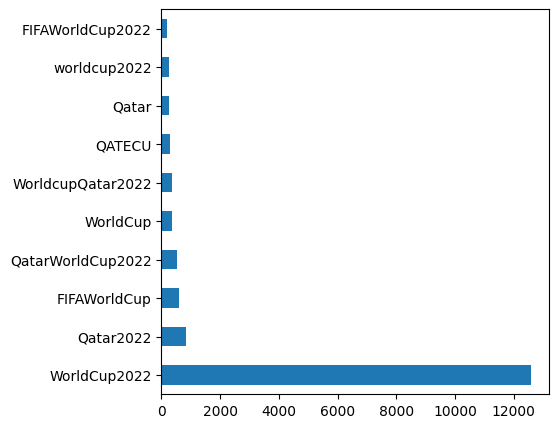

In [8]:
# Breakdown of the hashtags in the tweets
# top 10 most mentioned hashtags
ax = tweets['hashtags'].value_counts()[:10].plot(kind='barh', figsize=(5, 5))

The host country Qatar is a hot topic during the FIFA Word Cup period, with it being mentioned quite often.


In [9]:
# Tweets have some newline - need to replace 
def whitespace_sub(text):
    tabs= re.findall( '\n', text)
    for tab in tabs:
        text = text.replace(tab[0], ' ')
    return text

tweets['Tweet']= tweets['Tweet'].apply(whitespace_sub)


In [10]:
# username extraction from tweets
def extract_usernames(text):
    usernames = ()
    for word in text.lower().split():
        if word.startswith('@') and len(word) > 1:
            usernames = word[1:]
    return usernames


tweets['usernames'] = tweets['Tweet'].apply(lambda x: extract_usernames(x))



<AxesSubplot: >

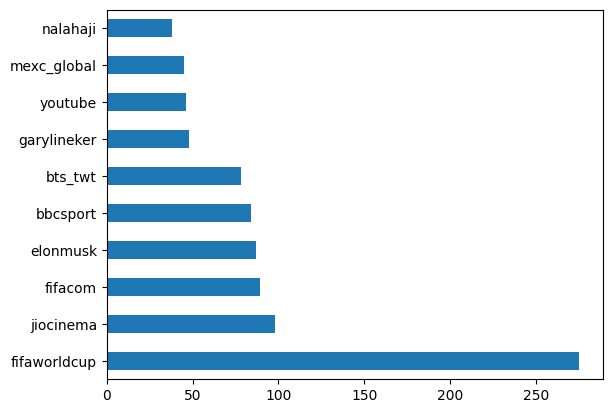

In [11]:
tweets1 = tweets[tweets['usernames'].astype(bool)]
usernames = tweets1['usernames'].value_counts()[:10]
usernames.plot(kind='barh')


BTS, the opening singer for the WordCup, and Elon Musk, the new Twitter's CEO, are mentioned the most during the event period

In [39]:
tweets.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,hashtags,usernames,tweet_lem,tweet_updated,scores,compound,vader_analysis
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe @MadBe...,neutral,WorldCup2022,al_goanna,drink today,what are we drinking today,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,WorldCup2022,canadasocceren,amaz launch video. show much face canada men n...,amazing launch video. shows how much the face ...,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",0.6239,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,WorldCup2022,(),worth read watch,worth reading while watching,"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...",0.2263,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright https://t.co/4A...,positive,FIFAKOOK,bts_twt,golden makna shin bright # # #,golden maknae shinning bright # # #,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",0.4404,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,WorldCup2022,(),"bbc care much human rights, homosexu rights, w...","if the bbc cares so much about human rights, h...","{'neg': 0.065, 'neu': 0.87, 'pos': 0.065, 'com...",0.0000,neutral


### 2.2 Remove stop words

In [13]:
#download the stopword library
nltk.download("stopwords")

#save stop words as a set
stop_words = set(stopwords.words("english"))


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jkim2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#custom stop words - to minimize repeated words
new_stop_words = ['FIFA','WordCup2022','World Cup', 'worldcup', 'qatar', 'qatar2022','world','cup','worldcup2022','qatarworldcup2022', 'qatar2022', '2022',
                  'fifaworldcup','qatarworldcup2022','football', 'fifa', 'qatarworldcup']
all_stop_words = stop_words.union(new_stop_words)

# convert the stop words into a list
all_stop_words_list = list(all_stop_words)


In [15]:
#stemming
snow = nltk.stem.SnowballStemmer('english')


In [16]:
# Combine all above to one function to fix texts
def fix_Text(text):
	letters = re.sub("[^a-zA-Z]https?:\/\/\S*", " ", str(text)) #remove all non-letters and urls
	letters_1 = re.sub("#[A-Za-z0-9_]+", "",str(letters)) #remove all hashtags
	letters_2 = re.sub("@[A-Za-z0-9_]+", "",str(letters_1)) #remove all mentions
	letters_3 = re.sub(r'[^\x00-\x7F]+', ' ', str(letters_2))

	words = letters_3.lower().split() #make all letters lowercase
	meaningful = [snow.stem(word)
               for word in words if word not in all_stop_words] #convert to stemmed words
	return (" ".join(meaningful)) 


In [17]:
#apply the function on all the tweets
clean_tweets = tweets.Tweet.apply(fix_Text)
clean_tweets.head()

0                                          drink today
1    amaz launch video. show much face canada men n...
2                                     worth read watch
3                       golden makna shin bright # # #
4    bbc care much human rights, homosexu rights, w...
Name: Tweet, dtype: object

In [18]:
#check for empty documents
clean_tweets.isnull().sum()

0

In [19]:
# fix the format on sentiment tag
def fix_sentiment(df):
  df = df.replace(['NEU','NEUTRAL'], 'neutral')
  df = df.replace('POS', 'positive')
  df = df.replace('NEG', 'negative')

### 2.3 Create Word Clouds

In [20]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt


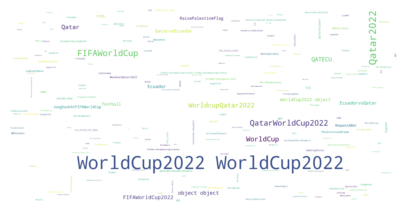

In [42]:
#need to convert from object dtypes to string
tweets['hashtags'] = tweets['hashtags'].astype(str)
# convert the list of hashtags into one global document for the wordcloud
hashtags = " ".join(tweets['hashtags'].tolist())

#create the wordcloud of all hashtags
hashtag_wordcloud = WordCloud(width=1600, height=800,
                              background_color='white').generate(hashtags)

# Display the wordcloud
plt.figure(figsize=(5, 5))
plt.imshow(hashtag_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


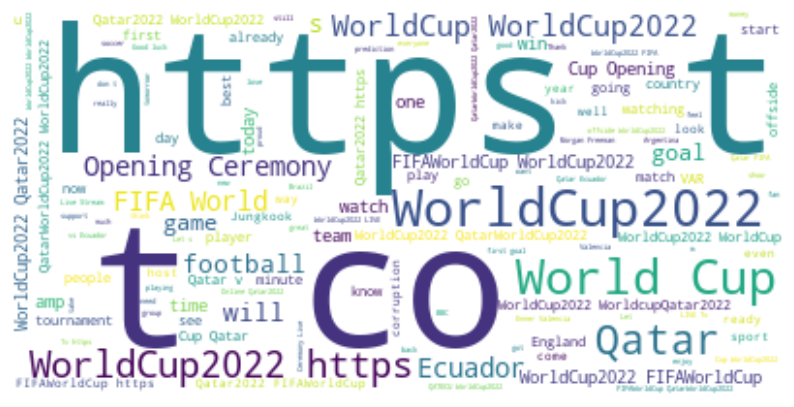

In [22]:
# word cloud for all the tweets
text_wc = " ".join(tweets['Tweet'].to_list())
wordcloud_tweets = WordCloud(background_color="white").generate(text_wc)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_tweets, interpolation="bilinear")
plt.axis("off")
plt.show()


### 2.4 Create TFIDF and Bag of Words

In [23]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()


In [24]:
# Combine all above to one function to fix texts
def fix_Text(text):
	letters = re.sub("[^a-zA-Z]https?:\/\/\S*", " ", str(text)
	                 )  # remove all non-letters and urls
	letters_1 = re.sub("#[A-Za-z0-9_]+", "", str(letters))  # remove all hashtags
	letters_2 = re.sub("@[A-Za-z0-9_]+", "", str(letters_1)
	                   )  # remove all mentions
	letters_3 = re.sub(r'[^\x00-\x7F]+', ' ', str(letters_2))

	words = letters_3.lower().split()  # make all letters lowercase
	meaningful = [snow.stem(word)
               for word in words if word not in all_stop_words]  # convert to stemmed words
	return (" ".join(meaningful))


#apply function
tweets['tweet_lem'] = tweets['Tweet'].apply(lambda x: fix_Text(x))

In [40]:
def fix_Text2(text):
	letters = re.sub("[^a-zA-Z]https?:\/\/\S*", " ", str(text)
	                 )  # remove all non-letters and urls
	letters_1 = re.sub("#[A-Za-z0-9_]+", "", str(letters))  # remove all hashtags
	letters_2 = re.sub("@[A-Za-z0-9_]+", "", str(letters_1)
	                   )  # remove all mentions
	letters_3 = re.sub(r'[^\x00-\x7F]+', ' ', str(letters_2))

	words = letters_3.lower().split()  # make all letters lowercase
	# meaningful = [snow.stem(word)
  #              for word in words if word not in all_stop_words] #convert to stemmed words
	return (" ".join(words))


#apply function
tweets['tweet_updated'] = tweets['Tweet'].apply(lambda x: fix_Text2(x))


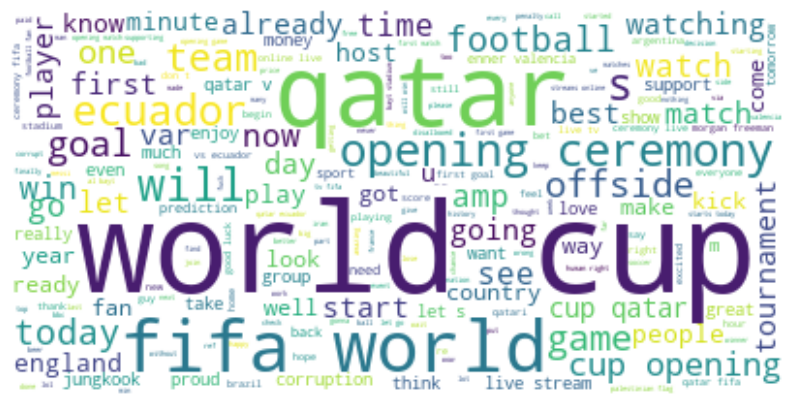

In [41]:
# word cloud for all the tweets
text_wc = " ".join(tweets['tweet_updated'].to_list())
wordcloud_tweets = WordCloud(background_color="white").generate(text_wc)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_tweets, interpolation="bilinear")
plt.axis("off")
plt.show()


In [26]:
cv = CountVectorizer(stop_words=all_stop_words_list, ngram_range=(
    1, 1), tokenizer=tweet_tokenizer.tokenize)
text_count = cv.fit_transform(tweets['tweet_lem'])


c:\Users\jkim2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\jkim2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['wordcup'] not in stop_words.
  warnings.warn(


In [27]:
text_count

<22524x16055 sparse matrix of type '<class 'numpy.int64'>'
	with 197572 stored elements in Compressed Sparse Row format>

##  **3. Sentiment Analysis Using Vader**

We want to create our own sentiment labeling using a different module to see if the sentiment tagging aligns between two methods and potentially reduce the amount of neutral tags because neutraulity does not tell us much.

In [28]:
!pip3 install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()


In [29]:
tweets['scores'] = tweets['Tweet'].apply(lambda Tweet: sent.polarity_scores(str(Tweet)))
tweets['compound']=tweets['scores'].apply(lambda score_dict:score_dict['compound'])
tweets['vader_analysis']=''
tweets.loc[tweets.compound>0,'vader_analysis']='positive'
tweets.loc[tweets.compound==0,'vader_analysis']='neutral'
tweets.loc[tweets.compound<0,'vader_analysis']='negative'
tweets.head()

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,hashtags,usernames,tweet_lem,tweet_updated,scores,compound,vader_analysis
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe @MadBe...,neutral,WorldCup2022,al_goanna,drink today,what are we drinking today,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,WorldCup2022,canadasocceren,amaz launch video. show much face canada men n...,amazing launch video. shows how much the face ...,"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",0.6239,positive
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,WorldCup2022,(),worth read watch,worth reading while watching,"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...",0.2263,positive
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright https://t.co/4A...,positive,FIFAKOOK,bts_twt,golden makna shin bright # # #,golden maknae shinning bright # # #,"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",0.4404,positive
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,WorldCup2022,(),"bbc care much human rights, homosexu rights, w...","if the bbc cares so much about human rights, h...","{'neg': 0.065, 'neu': 0.87, 'pos': 0.065, 'com...",0.0000,neutral


In [30]:
tweets['Sentiment'].value_counts()

positive    8489
neutral     8251
negative    5784
Name: Sentiment, dtype: int64

In [31]:
tweets['vader_analysis'].value_counts()

positive    10581
neutral      7379
negative     4564
Name: vader_analysis, dtype: int64

The Vader module reduces the neutral tags but it also decreases the count of negative Tweets in the dataset. From our research, Vader lexicon is trained with consideration of slangs and colloquialisms, so we believe it would be more suitable in evaluatinng Tweets' sentiment. In the Twitter world, users often use slangs, emojis, punctuations, etc to express their ideas, so taking in consideration these nuances would be more useful for us to understand the tweets' sentiments.


## **4. Models**

### 4.1 Logistic Regression -- using vader analysis as the known sentiment label

In [32]:
# split dataset to train and test
#By default, Sklearn train_test_split will make random partitions for the two subsets.
X_train, X_test, y_train, y_test = train_test_split(
    tweets['Tweet'], tweets['vader_analysis'], test_size=0.2)


In [33]:
#create TFIDF on the split sets
tf = TfidfVectorizer()
tf.fit(X_train)
x_train = tf.transform(X_train)
x_test = tf.transform(X_test)


In [34]:
#fit model on train test
from sklearn.linear_model import LogisticRegression

#set seed
random_seed = 42

lr = LogisticRegression(random_state=random_seed)
lr.fit(x_train, y_train)


c:\Users\jkim2\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [35]:
lr_predict = lr.predict(x_test)
lr_predict


array(['positive', 'positive', 'neutral', ..., 'negative', 'positive',
       'negative'], dtype=object)

In [36]:
# evaluate accurary
from sklearn.metrics import accuracy_score
print("Accuracy = {:.2f}%".format(accuracy_score(y_test, lr_predict)*100))


Accuracy = 79.07%


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test, lr_predict))


              precision    recall  f1-score   support

    negative       0.77      0.59      0.67       904
     neutral       0.79      0.84      0.81      1524
    positive       0.80      0.84      0.82      2077

    accuracy                           0.79      4505
   macro avg       0.78      0.76      0.77      4505
weighted avg       0.79      0.79      0.79      4505



In [38]:
#evaluate confusion matrix
cm2 = metrics.confusion_matrix(y_test,lr_predict)
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm2, display_labels=lr.classes_)
disp.plot()
plt.show()


NameError: name 'metrics' is not defined

### 4.2 Naive Bayes Model

In [ ]:
#By default, Sklearn train_test_split will make random partitions for the two subsets.
X_train, X_test, y_train, y_test = train_test_split(
    text_count, tweets['Sentiment'], test_size=0.2, random_state=5)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
#set seed
np.random.seed(42)
MNB = MultinomialNB()
MNB.fit(X_train,y_train)

MultinomialNB()

In [ ]:
nb_predict = MNB.predict(X_test)

In [ ]:
accuracy_score = metrics.balanced_accuracy_score(y_test,nb_predict)
print("NB Accuracy = {:.2f}%".format(accuracy_score*100))


NB Accuracy = 70.97%


In [ ]:
print(f"Classification Report:{metrics.classification_report(y_test,nb_predict)}")

Classification Report:              precision    recall  f1-score   support

    negative       0.63      0.78      0.70      1476
     neutral       0.72      0.54      0.62      2100
    positive       0.72      0.79      0.76      2055

    accuracy                           0.69      5631
   macro avg       0.69      0.70      0.69      5631
weighted avg       0.70      0.69      0.69      5631



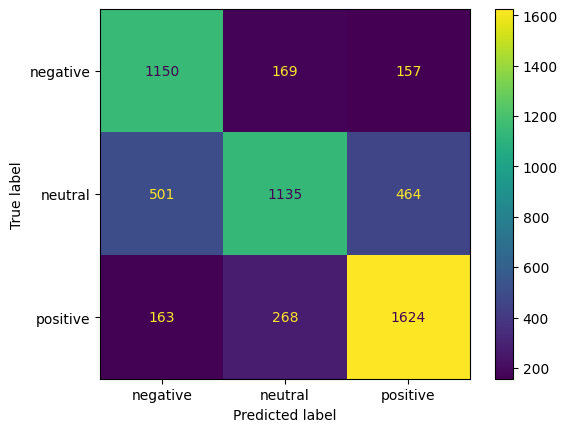

In [ ]:
cm = confusion_matrix(y_test,nb_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MNB.classes_)
disp.plot()
plt.show()

### 4.3 Random Forest Classifier (Ensemble Learning Model)

In [ ]:
#By default, Sklearn train_test_split will make random partitions for the two subsets.
X_train, X_test, y_train, y_test = train_test_split(
    tweets['tweet_updated'], tweets['Sentiment'], test_size=0.2)

In [ ]:
#convert the tweets to tfidf
tf = TfidfVectorizer()
tf.fit(X_train)
x_train2 = tf.transform(X_train) #matrix
x_test2 = tf.transform(X_test) #matrix

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=random_seed)
clf = clf.fit(x_train2,y_train)
rf_predict = clf.predict(x_test2)
accuracy_score2 = metrics.balanced_accuracy_score(y_test,rf_predict)

In [ ]:
print("RF Accuracy = {:.2f}%".format(accuracy_score2*100))

RF Accuracy = 67.71%


In [ ]:
print(f"Classification Report:{metrics.classification_report(y_test,rf_predict)}")

Classification Report:              precision    recall  f1-score   support

    negative       0.71      0.64      0.67      1149
     neutral       0.64      0.66      0.65      1648
    positive       0.71      0.73      0.72      1708

    accuracy                           0.68      4505
   macro avg       0.69      0.68      0.68      4505
weighted avg       0.68      0.68      0.68      4505



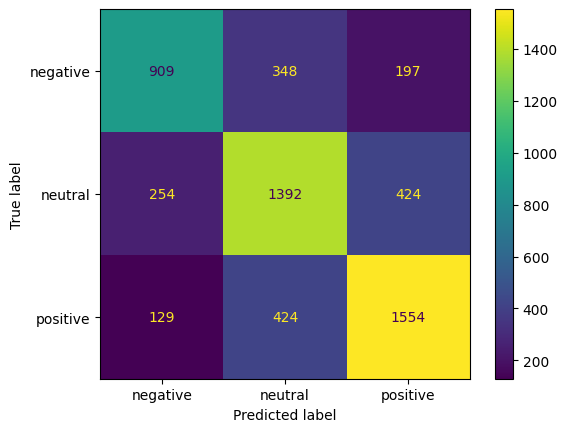

In [ ]:
#evaluate confusion matrix
cm1 = metrics.confusion_matrix(y_test,rf_predict)
disp = metrics.ConfusionMatrixDisplay(
    confusion_matrix=cm1, display_labels=clf.classes_)
disp.plot()
plt.show()


In [ ]:
RCF_preds_comparasion = pd.DataFrame()
RCF_preds_comparasion['RCF_prediction'] = y_predict
RCF_preds_comparasion['actual_sentiment'] = tweets['Sentiment']
RCF_preds_comparasion['tweet'] = tweets['Tweet']
RCF_preds_comparasion.head(10)

,RCF_prediction,actual_sentiment,tweet
0,negative,neutral,What are we drinking today @TucanTribe @MadBe...
1,neutral,positive,Amazing @CanadaSoccerEN #WorldCup2022 launch ...
2,neutral,positive,Worth reading while watching #WorldCup2022 htt...
3,positive,positive,Golden Maknae shinning bright https://t.co/4A...
4,neutral,negative,"If the BBC cares so much about human rights, h..."
5,negative,negative,"And like, will the mexican fans be able to scr..."
6,negative,neutral,Look like a only me and the Jamaican football ...
7,neutral,negative,Really? Football on a Monday morning at 9 and ...
8,positive,positive,"As the World Cup starts in Qatar, it’s Black A..."
9,negative,positive,#WorldCup2022 @ITVSport &amp; @LFSYSTEMMUSIC g...


## Transformer Based Model

In [ ]:
!pip3 install torch torchvision torchaudio


     -------------------------------------- 162.6/162.6 MB 8.1 MB/s eta 0:00:00
     ---------------------------------------- 1.1/1.1 MB 17.5 MB/s eta 0:00:00
     ---------------------------------------- 2.0/2.0 MB 2.0 MB/s eta 0:00:00


In [44]:
!pip install transformers
from transformers import pipeline
sentiment_pipeline = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis")

In [45]:
#sentiment analysis check
sentiment_pipeline("#Qatar tried to help its useless soccer team 5 minutes into the inaugural game, by denying an undoubtedly perfectly good goal to #Ecuador @ #WorldCup2022 ")

[{'label': 'NEG', 'score': 0.933708906173706}]

In [46]:
#get sentiment labels using the transformer package
def get_sentiment(tweet):
    sentiment = sentiment_pipeline(tweet)
    label = sentiment[0]['label']
   # print(label, tweet)
    return label
  

In [ ]:
# get sentiment scores
def get_score(tweet):
    sentiment = sentiment_pipeline(tweet)
    score = sentiment[0]['score']
    return score

In [ ]:
tweets['Transformer Sentiment'] = tweets['tweet_updated'].apply(lambda x: get_sentiment(x))
tweets['Transformer Score'] = tweets['tweet_updated'].apply(lambda x: get_score(x))

In [ ]:
tweets

,Date Created,Number of Likes,Source of Tweet,Tweet,Sentiment,hashtags,usernames,scores,compound,vader_analysis,tweet_updated,tweet_lem,Transformer Sentiment,Transformer Score
0,2022-11-20 23:59:21+00:00,4,Twitter Web App,What are we drinking today @TucanTribe @MadBe...,neutral,WorldCup2022,"[@TucanTribe, @MadBears_, @lkinc_algo, @al_goa...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,what are we drinking today,drink today,NEU,0.962463
1,2022-11-20 23:59:01+00:00,3,Twitter for iPhone,Amazing @CanadaSoccerEN #WorldCup2022 launch ...,positive,WorldCup2022,[@CanadaSoccerEN],"{'neg': 0.0, 'neu': 0.913, 'pos': 0.087, 'comp...",0.6239,positive,amazing launch video. shows how much the face ...,amaz launch video. show much face canada men n...,POS,0.992657
2,2022-11-20 23:58:41+00:00,1,Twitter for iPhone,Worth reading while watching #WorldCup2022 htt...,positive,WorldCup2022,[],"{'neg': 0.0, 'neu': 0.725, 'pos': 0.275, 'comp...",0.2263,positive,worth reading while watching,worth read watch,POS,0.753694
3,2022-11-20 23:58:33+00:00,1,Twitter Web App,Golden Maknae shinning bright https://t.co/4A...,positive,FIFAKOOK,[@BTS_twt],"{'neg': 0.0, 'neu': 0.861, 'pos': 0.139, 'comp...",0.4404,positive,golden maknae shinning bright # # #,golden makna shin bright # # #,POS,0.947304
4,2022-11-20 23:58:28+00:00,0,Twitter for Android,"If the BBC cares so much about human rights, h...",negative,WorldCup2022,[],"{'neg': 0.065, 'neu': 0.87, 'pos': 0.065, 'com...",0.0000,neutral,"if the bbc cares so much about human rights, h...","bbc care much human rights, homosexu rights, w...",NEG,0.670875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22519,2022-11-20 00:00:21+00:00,1,Twitter Web App,Here We go World cup 2022 #WorldCup2022,positive,WorldCup2022,[],"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,here we go world cup 2022,go,POS,0.802778
22520,2022-11-20 00:00:03+00:00,0,DenetPro,Anderlecht confirms former Viborg FF's Jesper ...,neutral,Brasil,[],"{'neg': 0.045, 'neu': 0.717, 'pos': 0.238, 'co...",0.8555,positive,anderlecht confirms former viborg ff's jesper ...,anderlecht confirm former viborg ff jesper fre...,NEU,0.926596
22521,2022-11-20 00:00:01+00:00,2,Twitter for iPhone,Great thread to read before the start of #Worl...,positive,WorldCup2022,[],"{'neg': 0.0, 'neu': 0.687, 'pos': 0.313, 'comp...",0.6249,positive,great thread to read before the start of,great thread read start,POS,0.984784
22522,2022-11-20 00:00:00+00:00,11,Twitter Web App,Raphinha wants Brazil to be united at the #Wor...,positive,WorldCup2022,[],"{'neg': 0.0, 'neu': 0.797, 'pos': 0.203, 'comp...",0.4215,positive,raphinha wants brazil to be united at the,raphinha want brazil unit,NEU,0.621201


In [ ]:
fix_sentiment(tweets['Transformer Sentiment'])

In [ ]:
fix_sentiment(tweets['vader_analysis'])

TypeError: ignored

In [ ]:
tweets.head()

AttributeError: ignored

In [ ]:
metrics.balanced_accuracy_score(tweets['Sentiment'],tweets['Transformer Sentiment'])

0.8112313726919536

In [ ]:
#compare all models
preds_comparasion = pd.DataFrame()
preds_comparasion['LR_prediction'] = lr_predict
preds_comparasion['NB_prediction'] = nb_predict
preds_comparasion['RF_prediction'] = rf_predict

preds_comparasion['original_sentiment'] = tweets['Sentiment']
preds_comparasion['vader_sentiment'] = tweets['vader_analysis']
preds_comparasion['tweet'] = tweets['Tweet']
preds_comparasion.head(50)


,LR_prediction,NB_prediction,RF_prediction,original_sentiment,vader_sentiment,tweet
0,neutral,neutral,neutral,neutral,neutral,What are we drinking today @TucanTribe @MadBe...
1,positive,negative,neutral,positive,positive,Amazing @CanadaSoccerEN #WorldCup2022 launch ...
2,negative,neutral,positive,positive,positive,Worth reading while watching #WorldCup2022 htt...
3,neutral,neutral,positive,positive,positive,Golden Maknae shinning bright https://t.co/4A...
4,neutral,neutral,neutral,negative,neutral,"If the BBC cares so much about human rights, h..."
5,neutral,neutral,negative,negative,negative,"And like, will the mexican fans be able to scr..."
6,negative,positive,neutral,neutral,positive,Look like a only me and the Jamaican football ...
7,positive,neutral,negative,negative,neutral,Really? Football on a Monday morning at 9 and ...
8,positive,negative,neutral,positive,negative,"As the World Cup starts in Qatar, it’s Black A..."
9,positive,negative,positive,positive,positive,#WorldCup2022 @ITVSport &amp; @LFSYSTEMMUSIC g...


The random forest model seems to has the worst accuracy score as well as the most disagreements with the other models' sentiment taggings. 